In [1]:
import numpy as np
import scipy.stats as stats

# scipy deprecation workaround
from scipy import stats
stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)

import pandas as pd
pd.options.mode.chained_assignment = None
pd.set_option('display.float_format', lambda x: '%.3f' % x)

import statsmodels.api as sm
import statsmodels.formula.api as smf

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# Data preparation

In [2]:
reg_table_f = '../data/reg_table.csv'
df = pd.read_csv(reg_table_f)
len(df)

2018697

In [3]:
df.head(2)

,PID,YEAR,MAIN_COUNTRY,N_AUTHORS,N_ADDRESSES,N_REFS,VENUE,IF,N_CITATIONS,GENDER_TOPIC,...,F_LAST_MESH,F_FIRST_MAIN_COUNTRY,F_LAST_MAIN_COUNTRY,GENDER_FL,F_MESH,F_COUNTRY,SRA,SRM,SRF,SRB
0,29496694,2008,United States,5,1,14,ADVANCES IN EXPERIMENTAL MEDICINE AND BIOLOGY,1.059,5,A,...,0.363,0.416,0.285,AA,0.445,0.351,0,0,0,0
1,29503162,2008,Netherlands,5,3,49,EXPERIMENTAL BRAIN RESEARCH,1.812,81,B,...,0.326,0.536,0.272,FA,0.408,0.404,1,1,1,1


In [4]:
df.columns

Index(['PID', 'YEAR', 'MAIN_COUNTRY', 'N_AUTHORS', 'N_ADDRESSES', 'N_REFS',
       'VENUE', 'IF', 'N_CITATIONS', 'GENDER_TOPIC', 'GENDER_FIRST',
       'GENDER_LAST', 'FEMALE_FRACTION', 'MALE_FRACTION', 'DISCIPLINE',
       'SUBDISCIPLINE', 'COUNTRY', 'CONTINENT', 'F_FIRST_MESH', 'F_LAST_MESH',
       'F_FIRST_MAIN_COUNTRY', 'F_LAST_MAIN_COUNTRY', 'GENDER_FL', 'F_MESH',
       'F_COUNTRY', 'SRA', 'SRM', 'SRF', 'SRB'],
      dtype='object')

# Data exploration

## Gender homophily

Is there a gender-homophily between the first and the last author?

In [5]:
ct = pd.crosstab(df.GENDER_FIRST, df.GENDER_LAST)
ct

GENDER_LAST,A,F
GENDER_FIRST,,
A,900858,267145
F,552599,298095


In [6]:
chi2, p, dof, expected = stats.chi2_contingency(ct)
print('p-value:', p)
print(expected)

p-value: 0.0
[[840959.35961217 327043.64038783]
 [612497.64038783 238196.35961217]]


Yes. Let's see the crosstab of author gender and sex reporting. 

In [7]:
pd.crosstab(df.GENDER_TOPIC.replace(dict(A=0, B=1, M=1, F=1)), df.GENDER_FIRST + df.GENDER_LAST)

col_0,AA,AF,FA,FF
GENDER_TOPIC,,,,
0,405917,119971,246861,117959
1,494941,147174,305738,180136


In [8]:
df.GENDER_TOPIC.replace(dict(A=0, B=1, M=1, F=1)).value_counts()

1    1127989
0     890708
Name: GENDER_TOPIC, dtype: int64

In [9]:
df.GENDER_TOPIC.isna().sum()

0

## MeSH features - missing data issue

In [10]:
print('Number of missing rows in F_FIRST_MESH:', df.F_FIRST_MESH.isna().sum(), df.F_FIRST_MESH.isna().sum()/len(df))
print('Number of missing rows in F_LAST_MESH:', df.F_LAST_MESH.isna().sum(), df.F_LAST_MESH.isna().sum()/len(df))
print('Remaining rows: ', len(df) - df.F_LAST_MESH.isna().sum())

Number of missing rows in F_FIRST_MESH: 745010 0.369054890357493
Number of missing rows in F_LAST_MESH: 745010 0.369054890357493
Remaining rows:  1273687


About 37% of the rows (papers) do not have the MeSH features. This means that either (i) these papers do not have any disease MeSH terms or (ii) they have disease MeSH terms that are too rare to be associated with a value (female author fraction). We follow the previous study and ignores them. 

# Analysis 

## multicollinearity

In [11]:
df.head()

,PID,YEAR,MAIN_COUNTRY,N_AUTHORS,N_ADDRESSES,N_REFS,VENUE,IF,N_CITATIONS,GENDER_TOPIC,...,F_LAST_MESH,F_FIRST_MAIN_COUNTRY,F_LAST_MAIN_COUNTRY,GENDER_FL,F_MESH,F_COUNTRY,SRA,SRM,SRF,SRB
0,29496694,2008,United States,5,1,14,ADVANCES IN EXPERIMENTAL MEDICINE AND BIOLOGY,1.059,5,A,...,0.363,0.416,0.285,AA,0.445,0.351,0,0,0,0
1,29503162,2008,Netherlands,5,3,49,EXPERIMENTAL BRAIN RESEARCH,1.812,81,B,...,0.326,0.536,0.272,FA,0.408,0.404,1,1,1,1
2,29503166,2008,United States,4,5,154,HEART FAILURE REVIEWS,3.485,53,A,...,0.266,0.416,0.285,AA,0.336,0.351,0,0,0,0
3,29503169,2008,United States,2,2,85,HEART FAILURE REVIEWS,3.485,45,A,...,0.254,0.416,0.285,AA,0.320,0.351,0,0,0,0
4,29503196,2008,Germany,7,5,28,INTERNATIONAL JOURNAL OF LEGAL MEDICINE,1.561,1,A,...,nan,0.403,0.196,FA,nan,0.299,0,0,0,0


In [12]:
temp = df[['GENDER_FL', 'YEAR', 'N_AUTHORS', 'CONTINENT', 'F_FIRST_MESH', 'F_LAST_MESH', 'F_FIRST_MAIN_COUNTRY', 'F_LAST_MAIN_COUNTRY']]
temp.head()

,GENDER_FL,YEAR,N_AUTHORS,CONTINENT,F_FIRST_MESH,F_LAST_MESH,F_FIRST_MAIN_COUNTRY,F_LAST_MAIN_COUNTRY
0,AA,2008,5,AA,0.526,0.363,0.416,0.285
1,FA,2008,5,Europe,0.490,0.326,0.536,0.272
2,AA,2008,4,AA,0.406,0.266,0.416,0.285
3,AA,2008,2,AA,0.386,0.254,0.416,0.285
4,FA,2008,7,Europe,nan,nan,0.403,0.196


In [13]:
temp.corr()

,YEAR,N_AUTHORS,F_FIRST_MESH,F_LAST_MESH,F_FIRST_MAIN_COUNTRY,F_LAST_MAIN_COUNTRY
YEAR,1.000,0.086,-0.005,-0.002,-0.036,-0.002
N_AUTHORS,0.086,1.000,-0.031,-0.058,-0.121,-0.114
F_FIRST_MESH,-0.005,-0.031,1.000,0.919,0.123,0.114
F_LAST_MESH,-0.002,-0.058,0.919,1.000,0.122,0.120
F_FIRST_MAIN_COUNTRY,-0.036,-0.121,0.123,0.122,1.000,0.854
F_LAST_MAIN_COUNTRY,-0.002,-0.114,0.114,0.120,0.854,1.000


In [14]:
np.linalg.cond(temp.corr())

26.605093198002862

Condition number is fairly large. There are strong correlations between F_FIRST and F_LAST. Let's create variables that by averaging them up. 


In [15]:
df['F_MESH'] = (df['F_FIRST_MESH'] + df['F_LAST_MESH']) / 2.0
df['F_COUNTRY'] = (df['F_FIRST_MAIN_COUNTRY'] + df['F_LAST_MAIN_COUNTRY'])/2.0

In [16]:
temp = df[['GENDER_FL', 'YEAR', 'N_AUTHORS', 'CONTINENT', 'F_MESH', 'F_COUNTRY']]
temp.corr()

,YEAR,N_AUTHORS,F_MESH,F_COUNTRY
YEAR,1.000,0.086,-0.004,-0.022
N_AUTHORS,0.086,1.000,-0.044,-0.122
F_MESH,-0.004,-0.044,1.000,0.127
F_COUNTRY,-0.022,-0.122,0.127,1.000


In [17]:
np.linalg.cond(temp.corr())

1.45253760701246

In [18]:
dm = pd.concat([pd.get_dummies(df.GENDER_FL)[['AF', 'FA', 'FF']], 
                pd.get_dummies(df.CONTINENT)[['Africa', 'Asia', 'Europe', 'Oceania', 'South America']], 
                pd.get_dummies(df.SUBDISCIPLINE)[list(df.SUBDISCIPLINE.value_counts().index)[1:]],
                df[['YEAR', 'N_AUTHORS', 'F_MESH', 'F_COUNTRY']]
               ], axis=1)
dm.head()

,AF,FA,FF,Africa,Asia,Europe,Oceania,South America,Neurology & Neurosurgery,General Biomedical Research,...,Anatomy & Morphology,Speech-Language Pathology and Audiology,Allergy,Biomedical Social Sciences,Microscopy,Social Studies of Medicine,YEAR,N_AUTHORS,F_MESH,F_COUNTRY
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,2008,5,0.445,0.351
1,0,1,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,2008,5,0.408,0.404
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,2008,4,0.336,0.351
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,2008,2,0.320,0.351
4,0,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,2008,7,nan,0.299


In [19]:
np.linalg.cond(dm.corr())

26.108549414714584

The condition index of the design matrix was calculated to estimate the strength of the multicollinearity. After merging first and last author covariates, the condition index was smaller than 30 (26.1). 


In [20]:
model = 'GENDER_TOPIC ~ GENDER_FL + np.log2(N_AUTHORS) + CONTINENT + YEAR + F_MESH + F_COUNTRY + SUBDISCIPLINE'
m1df = df.copy()
m1df.GENDER_TOPIC.replace(dict(A=0, B=1, M=1, F=1), inplace=True)
result = smf.logit(model, data=m1df).fit()


Optimization terminated successfully.
         Current function value: 0.544208
         Iterations 8


In [21]:
xdf = result.summary().tables[1]
xdf

,coef,std err,z,P>|z|,[0.025,0.975]
Intercept,5.2113,1.714,3.040,0.002,1.852,8.571
GENDER_FL[T.AF],0.0597,0.007,9.119,0.000,0.047,0.072
GENDER_FL[T.FA],0.0630,0.005,12.215,0.000,0.053,0.073
GENDER_FL[T.FF],0.2313,0.007,34.423,0.000,0.218,0.245
CONTINENT[T.Africa],1.0697,0.028,37.756,0.000,1.014,1.125
CONTINENT[T.Asia],0.4913,0.007,73.224,0.000,0.478,0.504
CONTINENT[T.Europe],0.1412,0.005,27.639,0.000,0.131,0.151
CONTINENT[T.Oceania],0.0420,0.013,3.346,0.001,0.017,0.067
CONTINENT[T.South America],0.3170,0.013,24.151,0.000,0.291,0.343
SUBDISCIPLINE[T.Allergy],-1.3039,0.052,-25.246,0.000,-1.405,-1.203


## Discipline-wise models

Let's fit four models. The first one uses the whole dataset while the other three use one of the major disciplines. 

In [25]:
model = 'GENDER_TOPIC ~ GENDER_FL + np.log2(N_AUTHORS) + CONTINENT + YEAR + F_MESH + F_COUNTRY + SUBDISCIPLINE'
tempdf = df.replace({'GENDER_TOPIC': dict(A=0, B=1, M=1, F=1)})

result0 = smf.logit(model, data=tempdf).fit()
result_b = smf.logit(model, data=tempdf[tempdf.DISCIPLINE=='Biomedical Research']).fit() 
result_c = smf.logit(model, data=tempdf[tempdf.DISCIPLINE=='Clinical Medicine']).fit() 
result_h = smf.logit(model, data=tempdf[tempdf.DISCIPLINE=='Health']).fit() 

Optimization terminated successfully.
         Current function value: 0.544208
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.634324
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.523831
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.534813
         Iterations 6


In [26]:
results = (result0, result_b, result_c, result_h)

In [27]:
# see the workflow
# open('../results/br_sr_mesh_ctry.csv', 'w').write(result_b.summary().as_csv())
# open('../results/cm_sr_mesh_ctry.csv', 'w').write(result_c.summary().as_csv())
# open('../results/h_sr_mesh_ctry.csv', 'w').write(result_h.summary().as_csv())

2918

## Plotting Odds ratio

Let's first define a function for drawing the figures. It returns odd ratios and CIs for a given set of independent variables. 


In [28]:
def ors_and_errs(result, IVs):
    ORs = [np.exp(result.params[iv]) for iv in IVs]
    err_l = [np.exp(result.params[iv]) - np.exp(result.conf_int()[0][iv]) for iv in IVs]
    err_u = [np.exp(result.conf_int()[1][iv]) - np.exp(result.params[iv])for iv in IVs]
    return ORs, err_l, err_u

And these are the independent variables that we are interested in. 

In [29]:
IVs = ['GENDER_FL[T.AF]', 'GENDER_FL[T.FA]', 'GENDER_FL[T.FF]', 'np.log2(N_AUTHORS)',
       'F_MESH', 'F_COUNTRY',
       'CONTINENT[T.Africa]', 'CONTINENT[T.Asia]', 'CONTINENT[T.Europe]',
       'CONTINENT[T.Oceania]', 'CONTINENT[T.South America]',
       'YEAR']
labels = ['Male-Female', 'Female-Male', 'Female-Female', '# authors (log2)', 
          'f_mesh', 'f_country',
          'Africa', 'Asia', 'Europe', 'Oceania', 'S. America',
          'Year']
IVs.reverse()
labels.reverse()

Let's define a function that draws a single plot. 

In [30]:
def plot_ors_on_ax(ax, title, Y, result, IVs, labels, xlim=(None, None),
                    elinewidth=0.8, markersize=3):
    
    ors, err_l, err_u = ors_and_errs(result, IVs)
    ax.errorbar(ors, Y, xerr=[err_l, err_u], 
                 fmt='o', color='k', elinewidth=elinewidth, markersize=markersize, mew=0.5)
    ax.set_xscale("log")
    ax.set_title(title)
    ax.axhline(y=1.5, color='0.8', linewidth=0.5)
    ax.axhline(y=6.5, color='0.8', linewidth=0.5)
    #ax.axhline(y=8.5, color='0.8', linewidth=0.5)
    ax.axvline(x=1, color='r', linewidth=0.5)
    ax.set_xlim(xlim)
    ax.set_xlabel('Odds Ratio (log-scale)')
    ax.set_xticks([1.0, 2.0, 5.0])
    ax.xaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())
    ax.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())


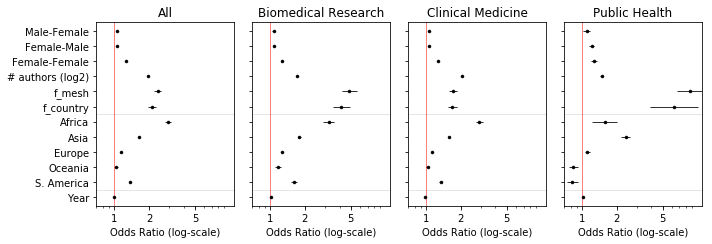

In [31]:
fig, axes = plt.subplots(nrows=1, ncols=4, sharey=True, figsize=(10,3.5))
fig.subplots_adjust(wspace=0)
Y = np.arange(1, len(IVs)+1)
xlim = (0.7, 11)

for idx, (result, label) in enumerate(zip(results, ['All', 'Biomedical Research', 
                                                    'Clinical Medicine', 'Public Health'])):
    plot_ors_on_ax(axes[idx], label, Y=Y, result=result, IVs=IVs, labels=labels, xlim=xlim)

plt.yticks(Y, labels)
plt.tight_layout()
fig.savefig('model1_ors.pdf')